In [1]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

In [2]:
# Eq. 25, https://en.wikipedia.org/wiki/Kepler_orbit#Properties_of_trajectory_equation
# Note eq. 24 implies a unique E for all t and 0 < e < 1.
t2E = lambda e, t : fsolve(lambda E : E - e*np.sin(E) - t, t/(1 - e))

In [3]:
circlexy = lambda r, θ : (r*np.cos(θ), r*np.sin(θ))

In [4]:
e = .1                   # eccentricity
G = 6.67430e-11          # gravitational constant, m³/(kg s²) https://en.wikipedia.org/wiki/Gravitational_constant
m = [1e3, 5.9722e24]     # masses of satellite, earth, kg https://en.wikipedia.org/wiki/Earth_mass
N = 250                   # nu. plot points
R = 6371.0088e3          # mean earth radius, m https://en.wikipedia.org/wiki/Earth_radius
α = G*sum(m)             # gravitational parameter, eq. 1, m³/s²
a = (R + 4e5)/(1 - e)    # eq. 35, R + minimum altitude solved for semi-major axis, m
p = a*(1 - e*e)          # eqs. 13--14, r(θ=π/2), θ being the true anomaly
b = a*(1 - e*e)**.5      # eq. 15, semi-minor axis
H = (α*p)**.5            # eq. 26, specific relative angular-momentum magnitude, m²/s
P = 2*np.pi*a**1.5/α**.5 # eq. 43, orbital period for an elliptic orbit, s
t = np.linspace(0,
               .99*P, N) # time list, s
E = t2E(e, H*t/a/b)      # eq. 25, eccentric anomaly list, radians
x = a*(np.cos(E) - e)    # eq. 20, x-coordinate list
y = b*np.sin(E)          # eq. 21, y-coordinate list

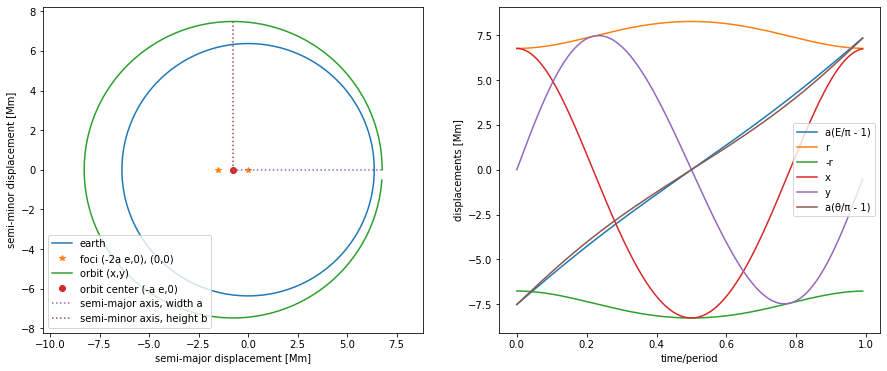

In [5]:
#plt.plot(t/24/3600, E)
X = circlexy(R/1e6,        # curve of earth section by orbital plane
             np.linspace(0, 2*np.pi, N))
f = plt.figure(figsize=(15,6))
ax = [f.add_subplot(1,2,1), f.add_subplot(1,2,2)]
ax[0].plot(X[0], X[1], label='earth')
ax[0].plot([0, -2*a*e/1e6], [0, 0], '*', label='foci (-2a e,0), (0,0)')
ax[0].plot(x/1e6, y/1e6, label='orbit (x,y)')
ax[0].plot(-a*e/1e6, 0, 'o', label='orbit center (-a e,0)')
ax[0].plot(np.array([-e, 1 - e])*a/1e6, np.array([0, 0]), ':', label='semi-major axis, width a')
ax[0].plot(-np.array([1, 1])*a*e/1e6, np.array([0, 1])*b/1e6, ':', label='semi-minor axis, height b')
ax[0].set_xlabel('semi-major displacement [Mm]')
ax[0].set_ylabel('semi-minor displacement [Mm]')
ax[0].axis('equal')
ax[0].legend(loc='lower left')
ax[1].plot(t/P, a*(E/np.pi - 1)/1e6, label='a(E/π - 1)')
ax[1].plot(t/P, a*(1 - e*np.cos(E))/1e6, label='r')
ax[1].plot(t/P, a*(e*np.cos(E) - 1)/1e6, label='-r')
ax[1].plot(t/P, x/1e6, label='x')
ax[1].plot(t/P, y/1e6, label='y')
ax[1].plot(t/P, a*(np.arctan2(y, x)/np.pi - 1 + 2*np.heaviside(t/P - .5, .5)
                  )/1e6, label='a(θ/π - 1)')
ax[1].set_xlabel('time/period')
ax[1].set_ylabel('displacements [Mm]')
ax[1].legend()

In [6]:
print(a)
print(b)

7523343.111111111
7485631.880598189


In [7]:
def xy2q(t, x, y, i, ω, Ω) : # map orbit to 3D coordinates (x,y) to (q[0],q[1],q[2])
    W = [np.cos(Ω),          # longitude of the ascending node converted to its cosine and sine
         np.sin(Ω)]
    ν = np.sin(i)             # sine of inclination angle
    l = ω + 2*np.pi*t/24/3600 # time (s) converted to orbital plane normal-vector azimuth (radian)
        # little omega is the arugment of pergigree
    ν = np.array([np.cos(l)*ν,# ν converted to unit normal vector of orbital plane
                  np.sin(l)*ν, np.array([np.cos(i)]*len(l))]).transpose()
    λ = np.cross([0, 0, 1], ν)# vector orthogonal to ν and to reference North Pole
    λ = np.diag(np.sum(λ*λ,   # normalize λ
                       axis=1)**-.5)@λ
    μ = np.cross(ν, λ)        # unit vector orthogonal to λ and to ν
    q = (np.diag(x)@λ + np.diag(y)@μ)@np.array([[W[0], -W[1], 0],
                                                [W[1],  W[0], 0],
                                                [   0,     0,  1]])
    return q


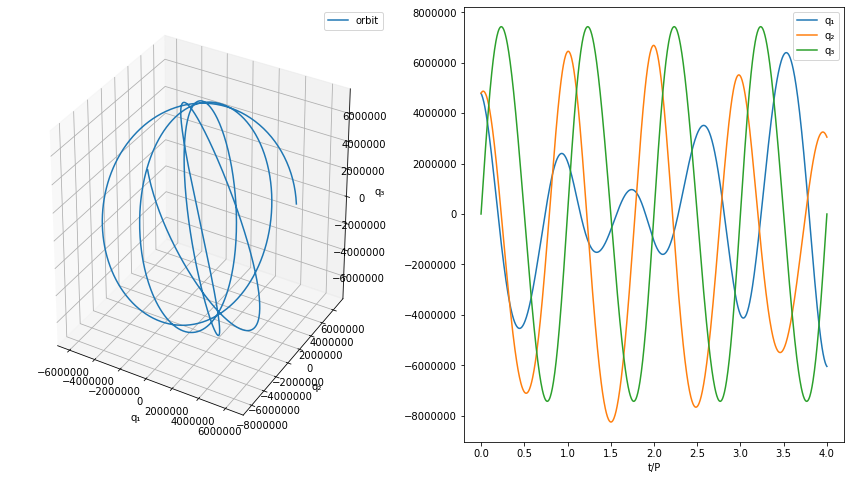

In [8]:
inclination = 1.449   # np.sin takes radians   83° × π/180 = 1.449rad
t = np.linspace(0,
               4*P, 4*N) # time list, s
E = t2E(e, H*t/a/b)      # eq. 25, eccentric anomaly list, radians
x = a*(np.cos(E) - e)    # eq. 20, x-coordinate list
y = b*np.sin(E)          # eq. 21, y-coordinate list
q = xy2q(t, x, y, inclination, 0, np.pi/4)
f = plt.figure(figsize=(15,8))
ax = [f.add_subplot(1,2,1,projection='3d'), f.add_subplot(1,2,2)]
ax[0].plot(q[:,0], q[:,1], q[:,2], label='orbit')
ax[0].set_xlabel('q₁')
#ax[0].set_xlim3d(-8, 8)
ax[0].set_ylabel('q₂')
#ax[0].set_ylim3d(-8, 8)
ax[0].set_zlabel('q₃')
#ax[0].set_zlim3d(-8, 8)
ax[0].legend()
ax[1].plot(t/P, q[:,0], label='q₁')
ax[1].plot(t/P, q[:,1], label='q₂')
ax[1].plot(t/P, q[:,2], label='q₃')
ax[1].set_xlabel('t/P')
ax[1].legend();

In [9]:
circlexyz = lambda r, θ, ω : (r*np.sin(θ)*np.cos(ω), r*np.sin(θ)*np.sin(ω),r*np.cos(θ) )

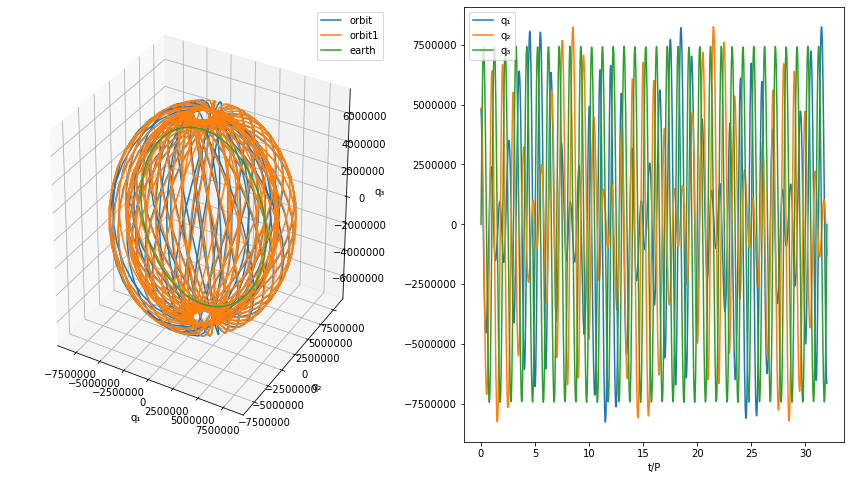

In [93]:
X = circlexyz( R, np.linspace(0, 2*np.pi, N), 0 )

PP = 32 # Number of orbits we wish to simulate
inclination =  1.449   # np.sin takes radians   83° × π/180 = 1.449rad
t = np.linspace(0, PP*P, 4*N) # time list, s
E = t2E(e, H*t/a/b)      # eq. 25, eccentric anomaly list, radians
x = a*(np.cos(E) - e)    # eq. 20, x-coordinate list
y = b*np.sin(E)          # eq. 21, y-coordinate list
q = xy2q(t, x, y, inclination, 0, np.pi/4)
q1 = xy2q(t, x, y, inclination, np.pi/2, np.pi/4)
f = plt.figure(figsize=(15,8))
ax = [f.add_subplot(1,2,1,projection='3d'), f.add_subplot(1,2,2)]
ax[0].plot(q[:,0], q[:,1], q[:,2], label='orbit')
ax[0].plot(q1[:,0], q1[:,1], q1[:,2], label='orbit1')
ax[0].plot(X[0], X[1], X[2], label='earth')
ax[0].set_xlabel('q₁')
#ax[0].set_xlim3d(-8, 8)
ax[0].set_ylabel('q₂')
#ax[0].set_ylim3d(-8, 8)
ax[0].set_zlabel('q₃')
#ax[0].set_zlim3d(-8, 8)
ax[0].legend()
ax[1].plot(t/P, q[:,0], label='q₁')
ax[1].plot(t/P, q[:,1], label='q₂')
ax[1].plot(t/P, q[:,2], label='q₃')
ax[1].set_xlabel('t/P')
ax[1].legend();

$\psi = arctan(\frac{q_1}{q_2})$

$\phi = arcsin(\frac{q_3}{|q|})$

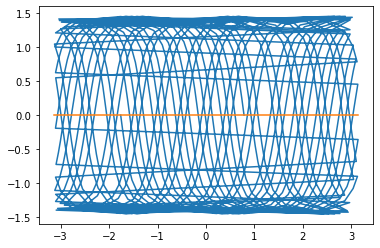

In [94]:
psi = np.arctan2(q[:,0], q[:,1]) 

qq = np.zeros(np.size(q[:,2]))
for i in range(0,np.size(q[:,1])):
    qq[i] = q[i,2] / np.sqrt( q[i,0]**2 + q[i,1]**2 + q[i,2]**2 )

phi = np.arcsin( qq )
plt.plot(psi, phi)
plt.plot([-np.pi,np.pi],[0,0])

In [95]:
# Setting up parameters needed to find area of
#               swath that crosses the equator
x1 = []
y1 = []
x2 = []
y2 = []
slope = []
tan_slope = []

In [96]:
# Finding when the satellite crosses the equator
#   and accumulating the points to form the line
for i in range(0,np.size(phi)-1):
    if( phi[i] > 0 and phi[i+1] < 0 ):
        x1.append( psi[i] )            # x1
        x2.append( psi[i+1] )          # x2
        y1.append( phi[i] )            # y1
        y2.append( phi[i+1] )          # y2
    else:
        if( phi[i] < 0 and phi[i+1] > 0 ):
            x1.append( psi[i] )            # x1
            x2.append( psi[i+1] )          # x2
            y1.append( phi[i] )            # y1
            y2.append( phi[i+1] )          # y2

In [97]:
# Calculating slope of the line crossing the equator.        
for i in range(0,np.size(x1)):
    m1 = y1[i] - y2[i]
    m2 = x1[i] - x2[i]
    m  = ( m1 / m2 )
    slope.append( m )  

In [98]:
# Calculating things from Aime's email
u1 = []
v1 = []
a1 = []
b1 = []
xx1 = []
xx2 = []
swath = .21
s = swath/2

for i in range(0,np.size(x1)):
    u1.append( x2[i] - x1[i] )
    v1.append( y2[i] - y1[i] )        

for i in range(0,np.size(x1)):
    a1.append( x1[i] - (u1[i]/v1[i])*y1[i] )
    b1.append( 0 )        

#colors = (0,0,0)
#plt.plot(psi, phi)
#plt.plot([-np.pi,np.pi],[0,0])
#plt.scatter(a1,b1,c=colors)

for i in range(0,np.size(x1)):
    xx1.append( a1[i] + s )
    xx2.append( a1[i] - s )

In [99]:
# Using what Greg thinks should work
theta = []
h = []
pp = []

for i in range(0,np.size(slope)):
    theta.append( np.arctan( slope[i] ) )

for i in range(0,np.size(theta)):
    h.append( s / (np.cos(theta[i])) )

for i in range(0,np.size(theta)):
    pp.append( h[i] / np.tan( theta[i] ) )

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


[-2.4849270603391775, 0.20627601833946477, -2.9571855269413145, -0.26594237370440565, 2.8537117206833424, -0.7381523274865716, 2.3814206809904785, -1.2104344230430508, 1.9091590242441803, -1.6828080839327846, 1.4369054448599359, -2.1550675181397803, 0.9646387555550324, -2.627272470766628, 0.4923382429942517, -3.0995033884083023, 0.0200624409926895, 2.7113436626597047, -0.45219316394626413, 2.2390103931024274, -0.9244497609581045, 1.7667842313822977, -1.3967305456298202, 1.2945779807440716, -1.869027556720872, 0.8223111984591763, -2.3412921042528634, 0.34993599019051413, -2.8135455342557427, -0.12233788916058946, 2.9973762590683117, -0.5945456805076774, 2.5250783377712316, -1.0667679630675548, 2.052797900403361, -1.5390857805618638, 1.5805407123517394, -2.01143847960219, 1.1082855516281738, -2.483674065821213, 0.6360111872561066, -2.955878249758275, 0.1637101738352803, 2.8550539036765112, -0.3085576960285722, 2.3826831022664674, -0.7808114115657974, 1.9103930839554477, -1.25307218706643

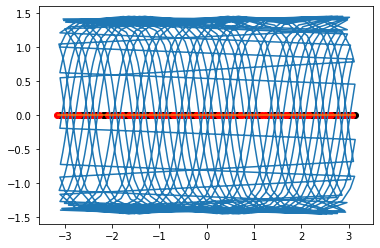

In [100]:
equator_catch_plus = []
equator_catch_minus = []
for i in range(0,np.size(x1)):
    equator_catch_plus.append( a1[i] + pp[i] )
    equator_catch_minus.append( a1[i] - pp[i] )
print(equator_catch_plus,'\n')
print(equator_catch_minus)

colors1 = (0,0,0)
colors2 = (1,0,0)
plt.plot(psi, phi)
plt.plot([-np.pi,np.pi],[0,0])
plt.scatter(equator_catch_plus,b1,c=colors1)
plt.scatter(equator_catch_minus,b1,c=colors2)

In [101]:
eq1 = []
eq2 = []

for i in range(0,np.size(equator_catch_plus),2):
    eq1.append( np.abs( equator_catch_plus[i] - equator_catch_minus[i] ) )
    
for i in range(1,np.size(equator_catch_plus),2):
    eq2.append( np.abs( equator_catch_plus[i] - equator_catch_minus[i] ) )
    
print(eq1,'\n')
print(eq2)

[0.21478931303775273, 0.21480245415076293, 0.21481593973667312, 0.2147952040571237, 0.21478770885652665, 0.21479332805339357, 0.21481215591592262, 0.2148054143452961, 0.21479038301996758, 0.2147885108722008, 0.21479976629960962, 0.21482000057130035, 0.21479734991447774, 0.21478797611261236, 0.21479172127684176, 0.21480864779713382, 0.2148086479053779, 0.2147917211872028, 0.21478797624725665, 0.2147973498651834, 0.21482000067444296, 0.21479976633152742, 0.21478851075200467, 0.21479038317848387, 0.21480541416619037, 0.21481215594972802, 0.21479332800032314, 0.2147877089791148, 0.2147952040154042, 0.21481593995842907, 0.2148024541048228, 0.21478931297866044] 

[0.21357599865390273, 0.21355318270453505, 0.21355938615247672, 0.2135948102079932, 0.21360231196051727, 0.213562641162645, 0.21355229768272999, 0.21357094474506777, 0.2136191896537527, 0.21358165833317244, 0.21355465839594512, 0.213556725892035, 0.2135879268513573, 0.2136104370164379, 0.2135664930839922, 0.2135520027468656, 0.21356

In [102]:
# This is beginning to make sure we don't capture the
#                   same area as we cross the equator

eq_crossed = []
for i in range(0,np.size(equator_catch_plus),2):
    xxx = equator_catch_plus[i]
    yyy = equator_catch_minus[i]
    for j in range(0,np.size(equator_catch_plus),2):
        if( j != i ):
            print('hi')
    
    
for i in range(1,np.size(equator_catch_plus),2):
    eq2.append( np.abs( equator_catch_plus[i] - equator_catch_minus[i] ) )

hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
h

In [103]:
# Need to pip install the below line to use interval
#pip install pyinterval

In [104]:
from interval import interval, inf, imath

In [105]:
checking_int = interval([1.0,3.0],[2.0,4.0],[7.0,10.0])
print(checking_int)

interval([1.0, 4.0], [7.0, 10.0])


In [108]:
interval_caught1 = []
interval_caught2 = []

for i in range(0,np.size(equator_catch_plus),2):
    if(equator_catch_plus[i] <= equator_catch_minus[i]):
        interval_caught1.append( [ np.pi + equator_catch_plus[i], equator_catch_minus[i] ] )
    else:
        interval_caught1.append( [ equator_catch_minus[i], equator_catch_plus[i] ] )
    
for i in range(1,np.size(equator_catch_plus),2):
    if(equator_catch_plus[i] <= equator_catch_minus[i]):
        interval_caught2.append( [ equator_catch_plus[i], equator_catch_minus[i] ] )
    else:
        interval_caught2.append( [ equator_catch_minus[i], equator_catch_plus[i] ] )
    
print(np.size(interval_caught1,0),interval_caught1,'\n')
print(interval_caught2)

print('\n')
area_passed_over_eq1 = interval_caught1[0]
for i in range(0,np.size(interval_caught1,0)):
    int1 = interval_caught1[i]
    area_passed_over_eq1 = interval( area_passed_over_eq1 ) | interval( int1 )

area_passed_over_eq2 = interval_caught2[0]
for i in range(0,np.size(interval_caught2,0)):
    int1 = interval_caught2[i]
    area_passed_over_eq2 = interval( area_passed_over_eq2 ) | interval( int1 )
    
print(area_passed_over_eq1)
print('\n')
print(area_passed_over_eq2)

32 [[-2.6997163733769303, -2.4849270603391775], [-3.1719879810920775, -2.9571855269413145], [2.6388957809466693, 2.8537117206833424], [2.166625476933355, 2.3814206809904785], [1.6943713153876536, 1.9091590242441803], [1.2221121168065423, 1.4369054448599359], [0.7498265996391098, 0.9646387555550324], [0.2775328286489556, 0.4923382429942517], [-0.19472794202727808, 0.0200624409926895], [-0.6669816748184649, -0.45219316394626413], [-1.1392495272577141, -0.9244497609581045], [-1.6115505462011206, -1.3967305456298202], [-2.08382490663535, -1.869027556720872], [-2.5560800803654757, -2.3412921042528634], [-3.0283372555325845, -2.8135455342557427], [2.782567611271178, 2.9973762590683117], [2.3102696898658537, 2.5250783377712316], [1.8380061792161584, 2.052797900403361], [1.3657527361044828, 1.5805407123517394], [0.8934882017629904, 1.1082855516281738], [0.42119118658166366, 0.6360111872561066], [-0.05108959249624713, 0.1637101738352803], [-0.5233462067805769, -0.3085576960285722], [-0.99560179

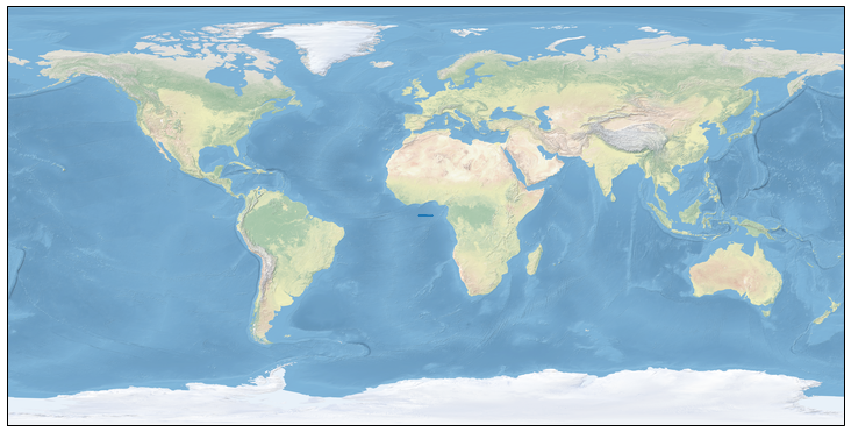

In [21]:
f = plt.figure(figsize=(15,8))
ax = f.add_subplot(1,1,1)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
plt.plot(psi, phi)